In [1]:
import matplotlib
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, h5py as h5, sys
from functools import partial
from pylab import cm
from PreFRBLE.likelihood import *
from PreFRBLE.convenience import *
from PreFRBLE.physics import *
from PreFRBLE.plot import *
from PreFRBLE.sample import *


fontsize=18


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}


matplotlib.rcParams.update({'font.size': fontsize, 'xtick.labelsize':fontsize, 'ytick.labelsize':fontsize})



### Local environment of Mangetar
Here we produce the likelihood function for the model analyzed in Piro & Gaensler 2018.
This is done via Monte-Carlo simulations using their theoretical predictions with samples of parameters that follow resonable prior distributions.

define all necessary functions for theoretical predictions for DM and RM in uniform ISM and wind-driven environment

In [2]:
## known constants

mu_e = 1.16 ## CHECK!!! electron mean molecular weight
mu = 1.16 ## CHECK !!! mean molecular weight
mu = 1.67 ## sun, 0.76 H, 0.26 He 0.01 Metal
mu = 0.62 ## Piro18 !!! why ???
mu_i = 1.3 ## Piro18

m_p = 1.67e-24 ## g
M_sun = 1.99e33 ## g
R_sun = 2.25e-8 ## pc
rho_nuc = 2.8e14 ## g cm^-3

pc2cm = 2.09e18 ## pc in cm

#x_ = v_rot/v_w * 10 ## p. 8, last pargraph  probably about 1
x__ = 0.1
x_ = x__ * 10
epsilon_B = 0.1  ## potion of shock energy that goes into magnetic energy
epsilon = epsilon_B*10

#a_c = 0.18 # for SM with n in cm^-3, L0 in pc

## units:
## E in 1e51 erg
## M in solar mass
## K in 1e13 g/cm
## t in years
## R in 100 R_sun
## B in G
## n in cm^-3, number density of uniform ambient ISM
## DM in pc cm^-3
## RM in rad m^-2
## SM in kpc m^-20/3
## tau in ms

## conversion factors
a_RM = 0.81e6 # rad m^-2 for n in cm^-3, R in pc and B in Gauss
a_SM = 0.18  # kpc m^-20/3  for n in cm^-3, R and L_0 in pc
a_tau= 1.8e5  # ms  for SM in kpc m^-20/3, D_eff in Gpc and lambda in m


## equations from Piro & Gaensler 2018

def t_ST( E, M, n ): ## yr
    return 210 * E**-0.5 * M**0.83 * n**-0.33 ## Eq. 1

def R_ST( M, n ):  ## pc
    return 2.2 * ( M / n )**(1./3)   ## Eq. 2

def v_ST( E, M ):  ## cm /s
    return 1e9 * E**0.5 * M**-0.5 ## Eq 3 in cm/s

def R_CH( M, K ): ## pc
    return 16.8 * M / K ## Eq. 33

def t_CH( E, M, K ):  ## yr
    return 1.9e3 * E**-0.5 * M**1.5 * K**-1  ## Eq. 34

def v_CH( E, M ): ## cm/s
    return 6.9 * 1e9 * E**0.5 * M**-0.5

def t_snow( E, n ):   ## yr
    ## results only applicable below this limit
    return 4.9e4 * E**0.22 * n**-0.55  ## Eq. 6

def t_max( E, n ):
    return t_snow( E, n )

def t_diss( L, B, dB, rho ): ## yr
    ## L in cm
    ## B, dB in G
    ## rho in g cm^-3
    return 600. * (L*1e-5)**1.6 * (dB*1e-16)**0.4 * (B*1e-16)**-1.6 * ( rho / rho_nuc )**1.2  ## (33) in Beloborodorov & Li 2016

def t_max( L, B, rho ):
    ## set dB ~ B
    return t_diss( L, B, B, rho )


def R(M): ## R_sun,  stellar radius from Radius-Mass relation
    return 1.33 * M**0.555 # Demircan & Kahraman 1990


## R's and v's from table 1 and 2

def v_R( t, typ='uniform' ):
    ## t must be in terms of t_st or t_ch !!!
    ## v is in terms of v_st or v_ch
#    t_st = t_ST( E, M, n )
    if typ == 'uniform':
        v_r_e = 1.41 * t**1.5 * ( 1 + 1.13*t**1.5 )**(-5./3)
        v_r_l = 0.37 + 0.03*t
    elif typ == 'wind':
        v_r_e = 1.06 * t**0.5 * ( 1 + 0.7*t**0.5 )**-3
        v_r_l = 0.19 + 0.02*t
    else:
        sys.exit( "typ %s not defined" % typ )
    return np.where( t < 1, v_r_e, v_r_l)
    

def v_B( t, typ='uniform'  ):
    ## t must be in terms of t_st or t_ch !!!
    ## v is in terms of v_st or v_ch
    if typ == 'uniform':
        v_b_e = 1.37 * ( 1 + 0.6*t**1.5 )**(-5./3)
        v_b_l = 0.63*( 1.56*t - 0.56 )**-0.6
    elif typ == 'wind':
        v_b_e = 1.79 * ( 1 + 0.33*t**0.5 )**-3
        v_b_l = 0.74 * ( 1.11*t - 0.11 )**(-1./3)
    else:
        sys.exit( "typ %s not defined" % typ )
    return np.where( t < 1, v_b_e, v_b_l)

def R_B( t, typ='uniform' ):
    ## t must be in terms of t_st or t_ch !!!
    ## R is in terms of R_st or R_ch
    if typ == 'uniform':
        R_b_e = 1.37* t * ( 1 + 0.6*t**1.5 )**(-2./3)
        R_b_l = ( 1.56*t - 0.56 )**0.4
    elif typ == 'wind':
        R_b_e = 1.79 * t * ( 1 + 0.33*t**0.5 )**-2
        R_b_l = ( 1.11*t - 0.11 )**(2./3)
    else:
        sys.exit( "typ %s not defined" % typ )
    return np.where( t < 1, R_b_e, R_b_l)

def R_C( t, typ='uniform' ):
    ## t must be in terms of t_st or t_ch !!!
    ## R is in terms of R_st or R_ch
    if typ == 'uniform':
        R_c_e = 1.24* t * ( 1 + 0.6*t**1.5 )**(-2./3)
        R_c_l = 0.91*( 1.56*t - 0.56 )**0.4
    elif typ == 'wind':
        R_c_e = 1.5 * t * ( 1 + 0.33*t**0.5 )**-2
        R_c_l = 0.84 * ( 1.11*t - 0.11 )**(2./3)
    else:
        sys.exit( "typ %s not defined" % typ )
    return np.where( t < 1, R_c_e, R_c_l)

def R_R( t, typ='uniform' ):
    ## t must be in terms of t_st or t_ch !!!
    ## R is in terms of R_st or R_ch
    if typ == 'uniform':
        R_r_e = 1.24* t * ( 1 + 1.13*t**1.5 )**(-2./3)
        R_r_l = t * ( 0.78 - 0.03*t - 0.37*np.log(t) )
    elif typ == 'wind':
        R_r_e = 1.5*t * ( 1 + 0.7*t**0.5 )**-2
        R_r_l = t * ( 0.54 - 0.02*t -0.19*np.log(t))
    else:
        sys.exit( "typ %s not defined" % typ )
    return np.where( t < 1, R_r_e, R_r_l)


def KineticEnergy( rho, v ):
    return 0.5 * rho * v**2

def Kinetic2MagneticEnergy( E_kin ):
    return np.sqrt( 0.8*np.pi * E_kin ) 

def B_SNR_uniform( M, t, R_st, v_st ): ## G
    ## t must be in terms of t_st
#    t_ = t/t_st( E, M, n )
    rho = 3./4/np.pi * M*M_sun * ( R_C( t ) * R_st * pc2cm )**-3 # density in g cm^-3
    return Kinetic2MagneticEnergy( KineticEnergy( rho, v_R( t )*v_st ) )
#    return np.sqrt( 0.8*np.pi * KineticEnergy( rho, v_R( t )*v_st ) ) 

def B_ISM( n, t, v_st ): ## G
    ## t must be in terms of t_st
    rho = 4 * n * m_p
    return Kinetic2MagneticEnergy( KineticEnergy( rho, v_B( t )*v_st ) )
#    return np.sqrt( 0.8*np.pi * KineticEnergy( rho, v_B( t )*v_st ) ) 


def RotationMeasure( DM, B ):
    ### returns  RM in rad m^-2
    ###  DM in pc cm^-3
    ###  B in G
    return a_RM * DM * B ## Eq. 26


## actual computation of DM, RM, SM and tau

def DMRM_uniform( E, M, n, t, SM=True, tau=True ):
    if tau:
        SM=True
    t_ = t / t_ST( E, M, n )
    n_r = mu/mu_e * 4 * n * ( v_B(t_)/v_R(t_) )**2 ## Eqs. 11 & 12
    R_b = R_B( t_ )
    R_c = R_C( t_ )
    R_r = R_R( t_ )
    R_st = R_ST( M, n )
    v_st = v_ST( E, M )
    dR_cr = np.where( R_r > 0, R_c - R_r, R_c ) * R_st  ## R_c where R_r < 0
    dR_bc = ( R_b - R_c ) * R_st
    DM_SNR = n_r * dR_cr ## Eq. 10
    DM_ISM = 4 * n * dR_bc ## Eq. 13
    RM_SNR = RotationMeasure( DM_SNR, B_SNR_uniform( M, t_, R_st, v_st ) )
    RM_ISM = RotationMeasure( DM_ISM, B_ISM( n, t_, v_st ) )
    results = [ DM_SNR + DM_ISM, RM_SNR + RM_ISM ]
    if SM:
        L0 = R_b * R_st
        SM_SNR = a_SM * L0**(-2./3) * n_r**2 * dR_cr
        SM_ISM = a_SM * L0**(-2./3) * 16 * n**2 * dR_bc
        results.append( SM_SNR + SM_ISM ) # full SM in kpc m^-20/3
        if tau:
            D_eff = R_b/2 * R_st * 1e-9 ## in Gpc
            results.append( ScatteringTime( SM=SM, redshift=0.0, D_eff=D_eff ) )  ## scattering time in ms for source at redshift z=0
    return results



def B_phi(  B_star, R_star, R_b, R_c, R_ch ): ## same units as B_star
    return 2 * B_star * x__ * R_star/R_ch * R_b / ( R_b**2 - np.where( R_c > 0, R_c, 0 )**2 )  

def B_SNR_wind( t, rho_w, v_ch ): ## G
    ## t must be in terms of t_ch
    return Kinetic2MagneticEnergy( KineticEnergy( rho_w, v_R( t, typ='wind' )*v_ch ) )
#    return np.sqrt( 0.8*np.pi * KineticEnergy( rho_w, v_R( t, typ='wind' )*v_ch ) )



def DMRM_wind( E, M, K, t, B_star, SNR_RM=False, SM=True, tau=True ):
    if tau:
        SM=True
    t_ = t / t_CH( E, M, K)
    R_ch = R_CH( M, K )
    v_ch = v_CH( E, M )
    R_b = R_B( t_, typ='wind' )
    R_c = R_C( t_, typ='wind' )
    R_r = R_R( t_, typ='wind' )
    dR_cr = np.where( R_r > 0, R_c - R_r, R_c ) * R_ch  ## R_c where R_r < 0
    dR_bc = np.where( R_c > 0, R_b - R_c, R_b ) * R_ch
    R_star = R(M)*R_sun
#    R_star = 100*R_sun ## to exactly mimic PG18
    
    rho_w = K * 1e13 * ( R_b*R_ch*pc2cm )**-2 ## Eq. 31
    n = 4 * rho_w / mu_e / m_p 
#    n_r = n * ( v_B(t_, typ='wind')/v_R(t_, typ='wind') )**2 ## Eq. 37
    n_r = n / mu_e * ( v_B(t_, typ='wind')/v_R(t_, typ='wind') )**2 ## Eq. 37
    DM_SNR = n_r * dR_cr ## Eq. 10
    DM_sh = n * dR_bc  ## Eq. 38
    DM_unsh = n / 4 * R_b * R_ch  ## Eq. 39
    
    RM_SNR = RotationMeasure( DM_SNR, B_SNR_wind( t_, rho_w, v_ch ) )
    RM_sh = RotationMeasure( DM_sh, B_phi( B_star, R_star, R_b, R_c, R_ch )  )
    results = [ DM_SNR + DM_sh + DM_unsh, RM_sh + RM_SNR*SNR_RM ]
    if SM:
        L0 = R_b * R_ch
        SM_SNR = a_SM * L0**(-2./3) * n_r**2 * dR_cr
        SM_sh = a_SM * L0**(-2./3) * n**2 * dR_bc
        SM_unsh = a_SM * L0**(-2./3) * n**2 / 16 * R_b * R_ch
        results.append( SM_SNR + SM_sh + SM_unsh )  # full SM in kpc m^-20/3
        if tau:
            D_eff = R_b/2 * R_ch * 1e-9 ## in Gpc
            results.append( ScatteringTime( SM=SM, redshift=0.0, D_eff=D_eff ) ) ## scattering time in ms for source at redshift z=0
    return results


###  compare to figures in PG18

RM results of wind case do only account for the region shocked by the wind, wile it does not include contribution from the SNR. The former naturally holds large scale magnetic field, which makes it a robust estimate, while the latter is probably more tangled. Hence the SNR+wind case is a too optimistic estimate.

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in power
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in power
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in power


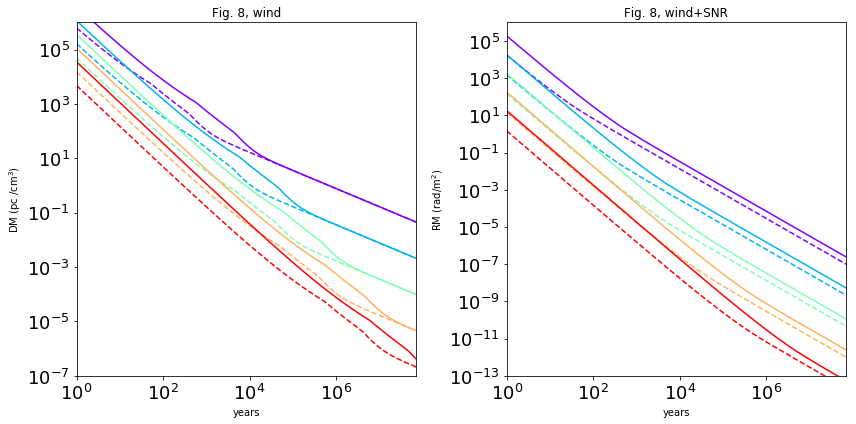

In [10]:
n0=1

fig, axs = plt.subplots( 1, 2, figsize=(12,6))

E=1
B=1
Ks = [1e-2, 1e-1, 1e0, 1e1, 1e2]
colors = cm.rainbow( np.linspace( 0, 1, len( Ks ) ) )

ts = 10.**np.linspace(0,8,100)

for K, color in zip( Ks[::-1], colors ):
    for M, line in zip( [10, 2], ['-','--'] ):
        t_f = np.inf #t_max( E, n0 ) * 1000
        hit = np.where( ts < t_f )[0]
#        for i in [0,1][:1]:
        DM, RM, SM, tau = DMRM_wind( E, M, K, ts, B, SNR_RM=0, SM=True, tau=True )
        axs[0].loglog( ts[hit], DM[hit], linestyle=line, color=color )
        axs[1].loglog( ts[hit], RM[hit], linestyle=line, color=color )
#            axs[i].loglog( ts[hit], DM[hit], linestyle=line, color=color )
#            axs[i].loglog( ts[hit], RM[hit], linestyle=line, color=color )
#            axs[i].loglog( ts[hit], SM[hit], linestyle=line, color=color )
#            axs[i].loglog( ts[hit], tau[hit], linestyle=line, color=color )
axs[0].set_title( 'Fig. 8, wind')
axs[0].set_xlabel('years')
axs[0].set_ylabel(r"DM (pc /cm$^3$)")
axs[0].set_xlim(1, 7e7)
axs[0].set_ylim(1e-7, 1e6)

axs[1].set_title( 'Fig. 8, wind+SNR')
axs[1].set_xlabel('years')
axs[1].set_ylabel(r"RM (rad/m$^2$)")
axs[1].set_xlim(1, 7e7)
axs[1].set_ylim(1e-13, 1e6)
plt.tight_layout()

### prior on age of magnetar
We now derive the prior distribution function for the time since SN t.
We use a flat distribution until the strong magnetic field of the magnetar dissipates.
The dissipation time t_diss is given in Beloborodov & Li 2016.
Since the parameters are distinct of and unrelated to parameters used in Piro & Gaensler 2018, we sample t_diss to derive the decay of P at high times.

In [4]:
## magnetic field of magnetars
def Sample_B_NS( N, mu=2.5e14, sigma=0.5 ):  ## standard values fitted to Ferrario & Wickramasinghe 2008, Fig 1
    y = np.random.lognormal( mean=np.log(mu), sigma=sigma, size=N )
    return y

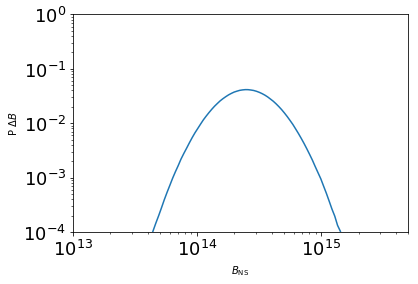

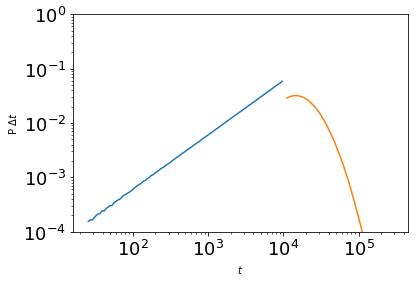

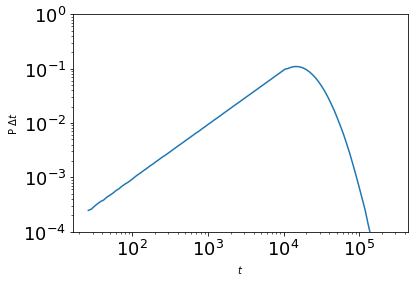

In [5]:
N = 10**7  ## sample size

## parameters assumed to be constant
L = 1e5 # cm
rho = 1e14 # g cm^-3

## sample magnetic field of magnetars
B = Sample_B_NS( N )
P, x = Histogram( B, bins=100, density=True, log=True )
PlotLikelihood( x, P, density=False,log=True )
plt.xlim(1e13,5e15)
plt.ylim(1e-4,1)
plt.xlabel( r"$B_{\rm NS}$" )
plt.ylabel( r"P $\Delta B$" )
plt.show()


fig, ax = plt.subplots()

## sample flat time at low t
# t, flat t_lo to t_hi, t_lo = 25 yr, Margalit et al. 2018, t_hi chosen for smooth transition
t_lo = 25
t_hi = 1e4
Sample_t = partial( np.random.uniform, high=t_hi, low=t_lo )

ts = Sample_t( size=N )

P, x = Histogram( ts, bins=100, density=True, log=True )
PlotLikelihood( x, P, density=False,log=True, ax=ax )


## compute dissipation time of sample
tdiss = t_max( L, B, rho )
## use only high t for smooth results
in_, = np.where( tdiss > t_hi*1.1 )

P_diss, x_diss = Histogram( tdiss[in_], bins=100, density=True, log=True )
PlotLikelihood( x_diss, P_diss, density=False, log=True, ax=ax )

ax.set_ylim(1e-4,1)
ax.set_xlabel( r"$t$" )
ax.set_ylabel( r"P $\Delta t$" )
plt.show()

## combine to single likelihood function
P_t, x_t = LikelihoodsAdd( [P, P_diss], [x,x_diss], weights=[1,1.2] )  # weights for smooth transition

PlotLikelihood( x_t, P_t, density=False,log=True )
#plt.xlim(1e13,5e15)
plt.ylim(1e-4,1)
plt.xlabel( r"$t$" )
plt.ylabel( r"P $\Delta t$" )
plt.show()

Pd_t = P_t*np.diff(x_t)


### sample priors
Here we sample the parameter spaces with prior distributions explained in more detail in Hackstein et al. 2019

In [4]:
# Energy of SN explosion E, lognormal, mu=2e51 erg,  sigma=5e50 erg
### !!! now set constant to 1.2e51 erg, see Woosley & Weaver 1995
mu = np.log(2)
sigma = 0.2
mu = np.log(1.8)
sigma = 0.15
#Sample_E = partial( np.random.lognormal, mean=mu, sigma=sigma )
Sample_E = lambda N: np.random.lognormal( size=N, mean=mu, sigma=sigma )
## use constant energy 1.2e51 erg instead
def Sample_E( N ):
    return 1.2

# mass of SN ejecta M, salpeter function - mass of neutron star
M_min, M_max = 20, 45 ## mass range of seed stars of magnetars, see Ferrario & Wickramasignhe 2008
M_NS = 1.5 ## mass of neutron star
def salpeter( m ):
    return m**(-2.35)
## invert cumulative distribution function u = F(M) => F^-1(u) = M, use uniform distribution (0,1) for u
def M_invert( u ):
#    return 30.2 / ( 4.467 - 3.78*u )**0.74
    return ( 0.017523 - 0.01166*u )**(-1./1.35)

def Sample_M( N ):
    u = np.random.uniform(low=0,high=1,size=N)
    return M_invert( u ) - M_NS


# wind mass loading parameter K, log-flat K_min=1e11 g/cm, K_max=1e15 g/cm
K_min, K_max = 1e-2, 1e2  ## in 1e13 g/cm
Sample_K = partial( SampleLogFlat, K_min, K_max)

''' # completely flat prior is not reasonable
# t, flat t_min to t_max, 
t_lo = 25
t_hi = 1e7
t_hi = 3e6
Sample_t = partial( np.random.uniform, high=t_hi, low=t_lo )
'''

from scipy.special import lambertw
# time since SN explosion t, flat from t_min to t_diss, then from sampled t_diss, see above
## t_min = 25 yr, Margalit et al. 2018, t_diss from Beloborodov & Li 2016
t_lo = 25
t_hi = 1e6
## invert cumulative distribution function u = F(t) => F^-1(u) = t, use uniform distribution (0,1) for u
def t_invert( u, a=7e-5, t1=t_lo, t_max=t_hi ):
    at1, at_max = a*t1, a*t_max
    c = ( 1 - u ) * np.exp( -at1 ) * ( at1 + 1 ) + u * np.exp( -at_max ) * ( at_max + 1 )
    return - np.real( lambertw( -c*np.exp(-1), k=-1 ) + 1 ) / a

def Sample_t( N ):
    u = np.random.uniform( low=0, high=1, size=N )
    return t_invert( u )
    




# ISM density n_ISM, ranges from Ferriere 2001 with known filling factors
n_ISM = np.array([
    [1e-4, 1e-2], # Hot Ionized Medium
    [0.2, 0.5],   # Warm Ionized and Neutral Medium
    [20, 50],     # Cold Neutral Medium
    [1e2, 1e4]    # HII regions
])
p_ISM = [
    0.53,         # Hot Ionized Medium
    0.43,         # Warm Ionized and Neutral Medium
    0.03,         # Cold Neutral Medium
    0.01          # HII regions    
]
th = [0]
th.extend( np.cumsum( p_ISM ) )


#### MW-like spiral

def Sample_n_Ferriere01( N ):
    ## choose which range to pick from for each pick
    r = np.random.uniform( low=0, high=1, size=N )
    res = []
    ## for each range
    for i, (t0, t1) in enumerate( zip( th[:-1], th[1:] ) ):
    ##   count picks 
        count = np.sum( (t0 < r)*(r < t1) )    
    ##   do the desired number of picks
        res.extend( SampleLogFlat( n_ISM[i][0], n_ISM[i][1], count ) )
    ## return all
    return np.array(res)
    
# magntic field of seed star B, log-flat 800 - 1500 G, compare Ferrario & Wickramasinghe 2008
B_min, B_max = 8e2, 1.5e3
Sample_B = partial( SampleLogFlat, B_min, B_max)



#### IC10

## number density of ISM n_ISM in IC10,  use Allivez 2005, Fig. 7
n_lo = 5e-3
n_hi = 3e0
Sample_n_IC10 = lambda N: SampleLogFlat( n_lo, n_hi, N )

## magnetic field of host dwarf galaxy iC10 B_Host,  use Chyzy 2016, Tab. 3
B_ic10_lo = 5e-1
B_ic10_hi = 5e0
Sample_B_IC10 = lambda N: SampleLogFlat( B_ic10_lo, B_ic10_hi, N )



#### Rodrigues et al. 2018   !!!! replace by someting reasonable !!!!!
n_lo = 5e-3
n_hi = 3e0
Sample_n_Rodrigues18 = lambda N: SampleLogFlat( n_lo, n_hi, N )






We check that the samples recreate the desired distribution

/data/PreFRBLE/PreFRBLE_venv/lib/python3.4/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


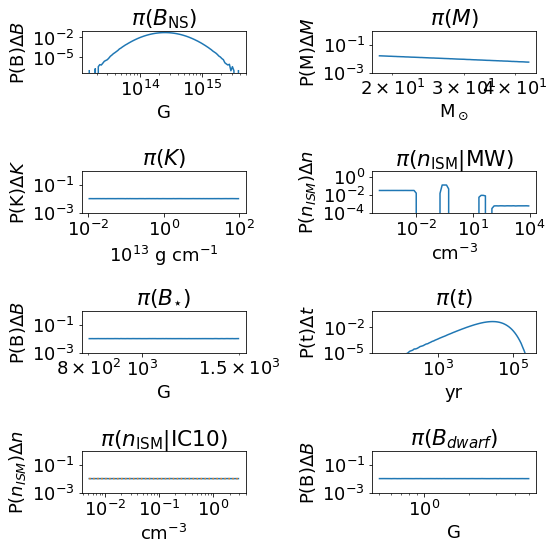

In [8]:
ylim = (1e-5,1)
#plt.figure( figsize=(12,10) )

N = 10**7

matplotlib.rc('font', **font)

fig, axs = plt.subplots( 4, 2, figsize=(8,8) )
axs = axs.flatten()

#plt.subplot(3, 2, 1)
B = Sample_B_NS( N )
P, x = Histogram(B, log=True, density=True, bins=100)
PlotLikelihood( x, P, density=False, label=r"$\pi(B_{\rm NS})$", ax=axs[0] )
axs[0].set_title( r"$\pi(B_{\rm NS})$" )
axs[0].set_ylabel("P(B)$\Delta B$")
axs[0].set_xlabel(r"G")
'''
E = Sample_E( N)
P, x = Histogram(E, log=True, density=True, bins=100)
PlotLikelihood( x, P, density=False, label="$\pi(E)$", ax=axs[0] )
axs[0].set_ylim(1e-5,1)
#axs[0].set_xlim(1,4)
axs[0].set_ylabel("P(E)$\Delta E$")
axs[0].set_xlabel(r"10$^{51}$ erg")
'''

#plt.subplot(3, 2, 2)
M = Sample_M( N)
P, x = Histogram(M, log=True, density=True, bins=100)
PlotLikelihood( x, P, density=False, label="$\pi(M)$", ax=axs[1] )
axs[1].set_title("$\pi(M)$")
axs[1].set_ylim(1e-3,1)
axs[1].set_ylabel("P(M)$\Delta M$")
axs[1].set_xlabel(r"M$_\odot$")

#plt.subplot(3, 2, 3)
K = Sample_K( N )
P, x = Histogram(K, log=True, density=True, bins=100)
PlotLikelihood( x, P, density=False, label=r"$\pi(K)$", ax=axs[2] )
axs[2].set_title( r"$\pi(K)$" )
axs[2].set_ylim(1e-3,1)
axs[2].set_ylabel(r"P(K)$\Delta K$")
axs[2].set_xlabel(r"$10^{13}$ g cm$^{-1}$")
axs[2].set_xticks( [1e-2, 1, 1e2])

#plt.subplot(3, 2, 4)
n = Sample_n_Ferriere01( N )
P, x = Histogram(n, log=True, density=True, bins=70)
PlotLikelihood( x, P, density=False, label=r"$\pi(n_{\rm ISM}|\rm MW)$", ax=axs[3] )
#n = Sample_n_IC10( N )
#P, x = Histogram(n, log=True, density=True, bins=100)
#PlotLikelihood( x, P, density=False, label=r"$\pi(n_{\rm ISM}|\rm IC10)$", ax=axs[3] )
axs[3].set_title( r"$\pi(n_{\rm ISM}|\rm MW)$" )
axs[3].set_ylim(1e-4,5)
axs[3].set_ylabel("P($n_{ISM}$)$\Delta n$")
axs[3].set_xlabel(r"cm$^{-3}$")

#plt.subplot(3, 2, 5)
B = Sample_B( N )
P, x = Histogram(B, log=True, density=True, bins=100)
PlotLikelihood( x, P, density=False, label=r"$\pi(B_{\star})$", ax=axs[4] )
axs[4].set_title( r"$\pi(B_{\star})$" )
axs[4].set_ylim(1e-3,1)
axs[4].set_ylabel("P(B)$\Delta B$")
axs[4].set_xlabel(r"G")
axs[4].set_xticks( [ 800, 1500], minor=True )

#plt.subplot(3, 2, 6)
t = Sample_t( N )
P, x = Histogram(t, log=True, density=True, bins=100)
PlotLikelihood( x, P, density=False, label=r"$\pi(t)$", ax=axs[5] )
axs[5].set_title( r"$\pi(t)$" )
axs[5].set_ylim(1e-5,1)
axs[5].set_ylabel("P(t)$\Delta t$")
axs[5].set_xlabel(r"yr")


n = Sample_n_IC10( N )
P, x = Histogram(n, log=True, density=True, bins=100)
PlotLikelihood( x, P, density=False, label=r"$\pi(n_{\rm ISM}|\rmIC10)$", ax=axs[6] )

n = Sample_n_Rodrigues18( N )
P, x = Histogram(n, log=True, density=True, bins=100)
PlotLikelihood( x, P, density=False, label=r"$\pi(n_{\rm ISM}|\rmIC10)$", ax=axs[6], linestyle=':' )

axs[6].set_title( r"$\pi(n_{\rm ISM}|\rmIC10)$" )
axs[6].set_ylim(1e-3,1)
axs[6].set_ylabel("P($n_{ISM}$)$\Delta n$")
axs[6].set_xlabel(r"cm$^{-3}$")

B = Sample_B_IC10( N )
P, x = Histogram(B, log=True, density=True, bins=100)
PlotLikelihood( x, P, density=False, label=r"$\pi(B_{\rm \it dwarf})$", ax=axs[7] )
axs[7].set_title( r"$\pi(B_{\rm \it dwarf})$" )
axs[7].set_ylim(1e-3,1)
axs[7].set_ylabel("P(B)$\Delta B$")
axs[7].set_xlabel(r"G")
#axs[7].set_xticklabels( [0.5,5], minor=True )



'''
for ax in axs:
    ax.legend()
'''
plt.tight_layout()
plt.show()



### Monte-Carlo Simulation
We compute the likelihood function in a Monte Carlo simulation. 
We use the samples created above to mimic candidates, compute the corresponding DM, RM, SM and tau as well as their distribution functions

In [5]:
from scipy.stats import gaussian_kde

def Likelihood_DMRM_uniform( N, bins=100, Sample_n=Sample_n_Ferriere01, SM=False, tau=False ):
    M = Sample_M( N )
    E = Sample_E( N )
    n = Sample_n( N )
    t = Sample_t( N )
    
    Ms = DMRM_uniform( E, M, n, t, SM=SM, tau=tau )

    results = []
    for i in range(len(Ms)):
        results.extend( Histogram( Ms[i], log=True, density=True, bins=bins ) )
    return results

def Likelihood_DMRM_wind( N, bins=100, SNR_RM=False, SM=False, tau=False):
    M = Sample_M( N )
    E = Sample_E( N )
    K = Sample_K( N )
    t = Sample_t( N )
    B = Sample_B( N )
    
    Ms = DMRM_wind( E, M, K, t, B, SNR_RM=SNR_RM, SM=SM, tau=tau )

    results = []
    for i in range(len(Ms)):
        results.extend( Histogram( Ms[i], log=True, density=True, bins=bins ) )
    return results


Check results

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in power
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in power
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in power
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in power
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in power
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in power


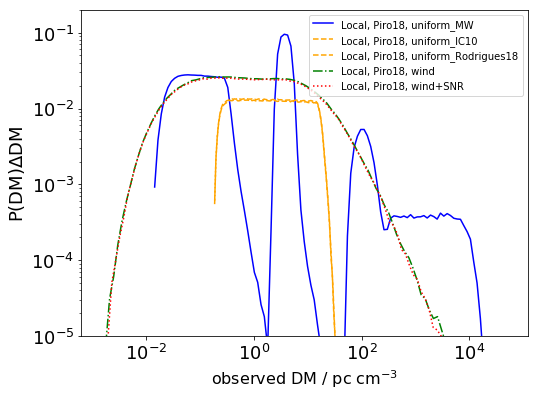

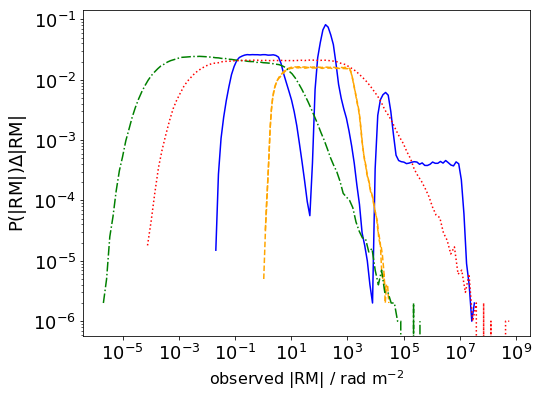

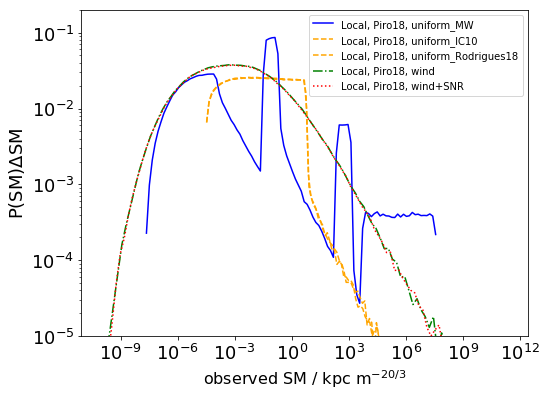

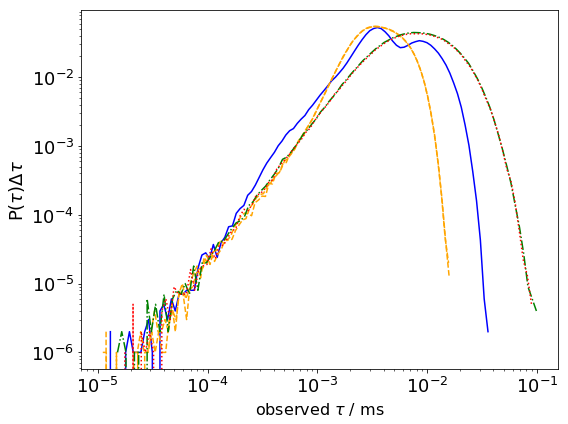

In [8]:
N = 10**6
bins = 100

#fig , axs = plt.subplots( 1, 3, figsize=(24,6), sharex='col', sharey='row' )
#axs = axs.flatten()

fig , ax1 = plt.subplots( 1, 1, figsize=(8,6))
fig , ax2 = plt.subplots( 1, 1, figsize=(8,6))
fig , ax3 = plt.subplots( 1, 1, figsize=(8,6))
fig , ax4 = plt.subplots( 1, 1, figsize=(8,6))
axs = [ax1,ax2,ax3,ax4]

fig.subplots_adjust( hspace=0, wspace=0 )

measures = ['DM', 'RM', 'SM', 'tau']

Ls = Likelihood_DMRM_uniform( N, bins=bins, Sample_n=Sample_n_Ferriere01, SM=True, tau=True )
for im, m in enumerate(measures):
    PlotLikelihood( x=Ls[2*im+1], P=Ls[2*im], density=False, label=r"Local, Piro18, uniform_MW", ax=axs[im], measure=m, color='blue'  )

Ls = Likelihood_DMRM_uniform( N, bins=bins, Sample_n=Sample_n_IC10, SM=True, tau=True )
for im, m in enumerate(measures):
    PlotLikelihood( x=Ls[2*im+1], P=Ls[2*im], density=False, label=r"Local, Piro18, uniform_IC10", ax=axs[im], measure=m, linestyle='--', color='orange'  )

Ls = Likelihood_DMRM_uniform( N, bins=bins, Sample_n=Sample_n_Rodrigues18, SM=True, tau=True )
for im, m in enumerate(measures):
    PlotLikelihood( x=Ls[2*im+1], P=Ls[2*im], density=False, label=r"Local, Piro18, uniform_Rodrigues18", ax=axs[im], measure=m, linestyle='--', color='orange'  )


Ls = Likelihood_DMRM_wind( N, bins=bins, SM=True, tau=True )
for im, m in enumerate(measures):
    PlotLikelihood( x=Ls[2*im+1], P=Ls[2*im], density=False, label=r"Local, Piro18, wind", ax=axs[im], measure=m, linestyle='-.', color='green'  )

Ls = Likelihood_DMRM_wind( N, bins=bins, SNR_RM=True, SM=True, tau=True )
for im, m in enumerate(measures):
    PlotLikelihood( x=Ls[2*im+1], P=Ls[2*im], density=False, label=r"Local, Piro18, wind+SNR", ax=axs[im], measure=m, linestyle=':', color='red'  )

'''
P_DM, x_DM, P_RM, x_RM = Likelihood_DMRM_uniform( N, bins=bins, Sample_n=Sample_n_Ferriere01 )
PlotLikelihood( x_DM, P_DM, density=False, label=r"Local, Piro18, uniform_MW", ax=axs[0], measure='DM', color='blue'  )
PlotLikelihood( x_RM, P_RM, density=False, label=r"Local, Piro18, uniform_MW", ax=axs[1], measure='RM', color='blue' )

P_DM, x_DM, P_RM, x_RM = Likelihood_DMRM_uniform( N, bins=bins, Sample_n=Sample_n_IC10 )
PlotLikelihood( x_DM, P_DM, density=False, label=r"Local, Piro18, uniform_IC10", ax=axs[0], measure='DM', linestyle='--', color='orange'  )
PlotLikelihood( x_RM, P_RM, density=False, label=r"Local, Piro18, uniform_IC10" , ax=axs[1], measure='RM', linestyle='--', color='orange' )


P_DM, x_DM, P_RM, x_RM = Likelihood_DMRM_wind( N, bins=bins )
PlotLikelihood( x_DM, P_DM, density=False, label=r"Local, Piro18, wind", ax=axs[0], measure='DM', linestyle='-.', color='green'  )
PlotLikelihood( x_RM, P_RM, density=False, label="Local, Piro18, wind", ax=axs[1], measure='RM', linestyle='-.', color='green' )

P_DM, x_DM, P_RM, x_RM = Likelihood_DMRM_wind( N, bins=bins, SNR_RM=True )
PlotLikelihood( x_DM, P_DM, density=False, label=r"Local, Piro18, wind+SNR", ax=axs[0], measure='DM', linestyle=':', color='red'  )
PlotLikelihood( x_RM, P_RM, density=False, label="Local, Piro18, wind+SNR", ax=axs[1], measure='RM', linestyle=':', color='red' )
'''

axs[0].set_ylim(1e-5,2e-1)
axs[2].set_ylim(1e-5,2e-1)

axs[0].legend()
axs[2].legend()
#for ax in axs:
#    ax.legend(loc='lower center')

plt.tight_layout()
plt.show()

### compute & write to file
Finally, compute all local environment models and write their likelihood functions to file.
Their position in the LikelihoodFile can be found by calling

<center> KeyLocal( "Piro18/" + model, <'DM', 'RM', 'SM' or 'tau'>, <'P' or 'x'> ) </center>



In [9]:
## this is the final list of local environment models in this work
local_models = ['uniform/JF12','uniform/Heesen11', 'uniform/Rodrigues18','wind','wind+SNR']
## names and samples of host model for uniform PG18 model
Host_models = ['JF12', 'Heesen11', 'Rodrigues18']
Host_samples = [Sample_n_Ferriere01, Sample_n_IC10, Sample_n_Rodrigues18]

def MakeLocalLikelihoods( N=10**7, bins=100 ):
    ## !!! ATTENTION !!! the order in which the models are computed should be the same as in local_models
    data = []
    for Host, sample_n in zip( Host_models, Host_samples ):
        data.extend( Likelihood_DMRM_uniform( N, bins=bins, Sample_n=sample_n, SM=True, tau=True ) )
    data.extend( Likelihood_DMRM_wind( N, bins=bins, SM=True, tau=True ) )
    data.extend( Likelihood_DMRM_wind( N, bins=bins, SNR_RM=True, SM=True, tau=True ) )
    keys = [ KeyLocal( '/'.join(["Piro18",m]), measure, axis ) for m in local_models for measure in ['DM', 'RM', 'SM', 'tau'] for axis in ['P','x']    ]
    Write2h5( likelihood_file_local, data, keys )

    

In [10]:
MakeLocalLikelihoods()

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in power
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in power
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in power
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in power
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in power
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in power
